In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import tensorflow_addons as tfa
import tensorflow_datasets as tfds

tfds.disable_progress_bar()
autotune = tf.data.experimental.AUTOTUNE
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"  
os.environ["CUDA_VISIBLE_DEVICES"] = '0'   
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"] = "true" 

In [2]:
from os import listdir
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img

def load_images(path, size=(256,256)):
    data_list = list()
    # enumerate filenames in directory, assume all are images
    for filename in listdir(path):
        # load and resize the image
        pixels = load_img(path + filename, target_size=size)
        # convert to numpy array
        pixels = img_to_array(pixels)

        data_list.append(pixels)
    return np.asarray(data_list)


In [3]:
builder_train = tfds.ImageFolder('./tmp_data/')
print(builder_train.info)
train_img = builder_train.as_dataset(split='image', shuffle_files=False,as_supervised=True)
train_IR = builder_train.as_dataset(split='masks', shuffle_files=False,as_supervised=True)

tfds.core.DatasetInfo(
    name='image_folder',
    version=1.0.0,
    description='Generic image classification dataset.',
    homepage='https://www.tensorflow.org/datasets/catalog/image_folder',
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/filename': Text(shape=(), dtype=tf.string),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=5),
    }),
    total_num_examples=15198,
    splits={
        'data': 0,
        'image': 7599,
        'masks': 7599,
    },
    supervised_keys=('image', 'label'),
    citation="""""",
    redistribution_info=,
)



In [4]:
builder_valid = tfds.ImageFolder('./tmp_val/')
print(builder_valid.info)
valid_img = builder_valid.as_dataset(split='image', shuffle_files=False,as_supervised=True)
valid_IR = builder_valid.as_dataset(split='masks', shuffle_files=False,as_supervised=True)

tfds.core.DatasetInfo(
    name='image_folder',
    version=1.0.0,
    description='Generic image classification dataset.',
    homepage='https://www.tensorflow.org/datasets/catalog/image_folder',
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/filename': Text(shape=(), dtype=tf.string),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    }),
    total_num_examples=444,
    splits={
        'image': 222,
        'masks': 222,
    },
    supervised_keys=('image', 'label'),
    citation="""""",
    redistribution_info=,
)



In [5]:
#dataset, _ = tfds.load("cycle_gan/horse2zebra", with_info=True, as_supervised=True)
#train_horses, train_zebras = dataset["trainC"], dataset["trainB"]
#test_horses, test_zebras = dataset["testA"], dataset["testB"]




# Define the standard image size.
orig_img_size = (360, 480)
# Size of the random crops to be used during training.
input_img_size = (256, 256, 3)
# Weights initializer for the layers.
kernel_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
# Gamma initializer for instance normalization.
gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

buffer_size = 512
batch_size = 1


def normalize_img(img):
    img = tf.cast(img, dtype=tf.float32)
    # Map values in the range [-1, 1]
    return (img / 127.5) - 1.0


def preprocess_train_image(img, label):
    img = tf.image.resize(img, [input_img_size[0], input_img_size[1]])
    img = normalize_img(img)
    return img


def preprocess_test_image(img, label):
    # Only resizing and normalization for the test images.
    img = tf.image.resize(img, [input_img_size[0], input_img_size[1]])
    img = normalize_img(img)
    return img

In [6]:
train_img = (
    train_img.map(preprocess_train_image, num_parallel_calls=autotune)
    .cache()
    .shuffle(buffer_size)
    .batch(batch_size)
)
train_IR = (
    train_IR.map(preprocess_train_image, num_parallel_calls=autotune)
    .cache()
    .shuffle(buffer_size)
    .batch(batch_size)
)

valid_img = (
    valid_img.map(preprocess_train_image, num_parallel_calls=autotune)
    .cache()
    .shuffle(buffer_size)
    .batch(batch_size)
)
valid_IR = (
    valid_IR.map(preprocess_train_image, num_parallel_calls=autotune)
    .cache()
    .shuffle(buffer_size)
    .batch(batch_size)
)

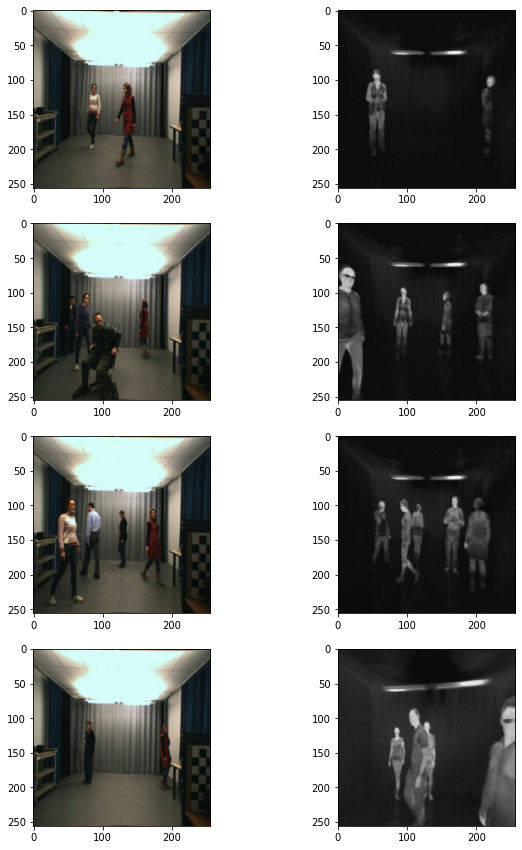

In [7]:
_, ax = plt.subplots(4, 2, figsize=(10, 15))
for i, samples in enumerate(zip(train_img.take(4), train_IR.take(4))):
    
    img=samples[0][0]
    img_m=samples[1][0]

    horse =(((img* 127.5) + 127.5).numpy().astype(np.uint8))
    zebra = (((img_m* 127.5) + 127.5).numpy().astype(np.uint8))
    ax[i, 0].imshow(horse)
    ax[i, 1].imshow(zebra)
plt.show()

In [8]:
class ReflectionPadding2D(layers.Layer):
    """Implements Reflection Padding as a layer.

    Args:
        padding(tuple): Amount of padding for the
        spatial dimensions.

    Returns:
        A padded tensor with the same type as the input tensor.
    """

    def __init__(self, padding=(1, 1), **kwargs):
        self.padding = tuple(padding)
        super(ReflectionPadding2D, self).__init__(**kwargs)

    def call(self, input_tensor, mask=None):
        padding_width, padding_height = self.padding
        padding_tensor = [
            [0, 0],
            [padding_height, padding_height],
            [padding_width, padding_width],
            [0, 0],
        ]
        return tf.pad(input_tensor, padding_tensor, mode="REFLECT")


def residual_block(
    x,
    activation,
    kernel_initializer=kernel_init,
    kernel_size=(3, 3),
    strides=(1, 1),
    padding="valid",
    gamma_initializer=gamma_init,
    use_bias=False,
):
    dim = x.shape[-1]
    input_tensor = x

    x = ReflectionPadding2D()(input_tensor)
    x = layers.Conv2D(
        dim,
        kernel_size,
        strides=strides,
        kernel_initializer=kernel_initializer,
        padding=padding,
        use_bias=use_bias,
    )(x)
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    x = activation(x)

    x = ReflectionPadding2D()(x)
    x = layers.Conv2D(
        dim,
        kernel_size,
        strides=strides,
        kernel_initializer=kernel_initializer,
        padding=padding,
        use_bias=use_bias,
    )(x)
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    x = layers.add([input_tensor, x])
    return x


def downsample(
    x,
    filters,
    activation,
    kernel_initializer=kernel_init,
    kernel_size=(3, 3),
    strides=(2, 2),
    padding="same",
    gamma_initializer=gamma_init,
    use_bias=False,
):
    x = layers.Conv2D(
        filters,
        kernel_size,
        strides=strides,
        kernel_initializer=kernel_initializer,
        padding=padding,
        use_bias=use_bias,
    )(x)
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    if activation:
        x = activation(x)
    return x


def upsample(
    x,
    filters,
    activation,
    kernel_size=(3, 3),
    strides=(2, 2),
    padding="same",
    kernel_initializer=kernel_init,
    gamma_initializer=gamma_init,
    use_bias=False,
):
    x = layers.Conv2DTranspose(
        filters,
        kernel_size,
        strides=strides,
        padding=padding,
        kernel_initializer=kernel_initializer,
        use_bias=use_bias,
    )(x)
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    if activation:
        x = activation(x)
    return x

In [9]:
def get_resnet_generator(
    filters=64,
    num_downsampling_blocks=2,
    num_residual_blocks=9,
    num_upsample_blocks=2,
    gamma_initializer=gamma_init,
    name=None,
):
    img_input = layers.Input(shape=input_img_size, name=name + "_img_input")
    x = ReflectionPadding2D(padding=(3, 3))(img_input)
    x = layers.Conv2D(filters, (7, 7), kernel_initializer=kernel_init, use_bias=False)(
        x
    )
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    x = layers.Activation("relu")(x)

    # Downsampling
    for _ in range(num_downsampling_blocks):
        filters *= 2
        x = downsample(x, filters=filters, activation=layers.Activation("relu"))

    # Residual blocks
    for _ in range(num_residual_blocks):
        x = residual_block(x, activation=layers.Activation("relu"))

    # Upsampling
    for _ in range(num_upsample_blocks):
        filters //= 2
        x = upsample(x, filters, activation=layers.Activation("relu"))

    # Final block
    x = ReflectionPadding2D(padding=(3, 3))(x)
    x = layers.Conv2D(3, (7, 7), padding="valid")(x)
    x = layers.Activation("tanh")(x)

    model = keras.models.Model(img_input, x, name=name)
    return model

In [10]:
def get_discriminator(
    filters=64, kernel_initializer=kernel_init, num_downsampling=3, name=None
):
    img_input = layers.Input(shape=input_img_size, name=name + "_img_input")
    x = layers.Conv2D(
        filters,
        (4, 4),
        strides=(2, 2),
        padding="same",
        kernel_initializer=kernel_initializer,
    )(img_input)
    x = layers.LeakyReLU(0.2)(x)

    num_filters = filters
    for num_downsample_block in range(3):
        num_filters *= 2
        if num_downsample_block < 2:
            x = downsample(
                x,
                filters=num_filters,
                activation=layers.LeakyReLU(0.2),
                kernel_size=(4, 4),
                strides=(2, 2),
            )
        else:
            x = downsample(
                x,
                filters=num_filters,
                activation=layers.LeakyReLU(0.2),
                kernel_size=(4, 4),
                strides=(1, 1),
            )

    x = layers.Conv2D(
        1, (4, 4), strides=(1, 1), padding="same", kernel_initializer=kernel_initializer
    )(x)

    model = keras.models.Model(inputs=img_input, outputs=x, name=name)
    return model


# Get the generators
gen_G = get_resnet_generator(name="generator_G")
gen_F = get_resnet_generator(name="generator_F")

# Get the discriminators
disc_X = get_discriminator(name="discriminator_X")
disc_Y = get_discriminator(name="discriminator_Y")

In [11]:
class CycleGan(keras.Model):
    def __init__(
        self,
        generator_G,
        generator_F,
        discriminator_X,
        discriminator_Y,
        lambda_cycle=10.0,
        lambda_identity=0.5,
    ):
        super(CycleGan, self).__init__()
        self.gen_G = generator_G
        self.gen_F = generator_F
        self.disc_X = discriminator_X
        self.disc_Y = discriminator_Y
        self.lambda_cycle = lambda_cycle
        self.lambda_identity = lambda_identity

    def compile(
        self,
        gen_G_optimizer,
        gen_F_optimizer,
        disc_X_optimizer,
        disc_Y_optimizer,
        gen_loss_fn,
        disc_loss_fn,
    ):
        super(CycleGan, self).compile()
        self.gen_G_optimizer = gen_G_optimizer
        self.gen_F_optimizer = gen_F_optimizer
        self.disc_X_optimizer = disc_X_optimizer
        self.disc_Y_optimizer = disc_Y_optimizer
        self.generator_loss_fn = gen_loss_fn
        self.discriminator_loss_fn = disc_loss_fn
        self.cycle_loss_fn = keras.losses.MeanAbsoluteError()
        self.identity_loss_fn = keras.losses.MeanAbsoluteError()

    def train_step(self, batch_data):
        # x is Horse and y is zebra
        real_x, real_y = batch_data

        # For CycleGAN, we need to calculate different
        # kinds of losses for the generators and discriminators.
        # We will perform the following steps here:
        #
        # 1. Pass real images through the generators and get the generated images
        # 2. Pass the generated images back to the generators to check if we
        #    we can predict the original image from the generated image.
        # 3. Do an identity mapping of the real images using the generators.
        # 4. Pass the generated images in 1) to the corresponding discriminators.
        # 5. Calculate the generators total loss (adverserial + cycle + identity)
        # 6. Calculate the discriminators loss
        # 7. Update the weights of the generators
        # 8. Update the weights of the discriminators
        # 9. Return the losses in a dictionary

        with tf.GradientTape(persistent=True) as tape:
            # Horse to fake zebra
            fake_y = self.gen_G(real_x, training=True)
            # Zebra to fake horse -> y2x
            fake_x = self.gen_F(real_y, training=True)

            # Cycle (Horse to fake zebra to fake horse): x -> y -> x
            cycled_x = self.gen_F(fake_y, training=True)
            # Cycle (Zebra to fake horse to fake zebra) y -> x -> y
            cycled_y = self.gen_G(fake_x, training=True)

            # Identity mapping
            same_x = self.gen_F(real_x, training=True)
            same_y = self.gen_G(real_y, training=True)

            # Discriminator output
            disc_real_x = self.disc_X(real_x, training=True)
            disc_fake_x = self.disc_X(fake_x, training=True)

            disc_real_y = self.disc_Y(real_y, training=True)
            disc_fake_y = self.disc_Y(fake_y, training=True)

            # Generator adverserial loss
            gen_G_loss = self.generator_loss_fn(disc_fake_y)
            gen_F_loss = self.generator_loss_fn(disc_fake_x)

            # Generator cycle loss
            cycle_loss_G = self.cycle_loss_fn(real_y, cycled_y) * self.lambda_cycle
            cycle_loss_F = self.cycle_loss_fn(real_x, cycled_x) * self.lambda_cycle

            # Generator identity loss
            id_loss_G = (
                self.identity_loss_fn(real_y, same_y)
                * self.lambda_cycle
                * self.lambda_identity
            )
            id_loss_F = (
                self.identity_loss_fn(real_x, same_x)
                * self.lambda_cycle
                * self.lambda_identity
            )

            # Total generator loss
            total_loss_G = gen_G_loss + cycle_loss_G + id_loss_G
            total_loss_F = gen_F_loss + cycle_loss_F + id_loss_F

            # Discriminator loss
            disc_X_loss = self.discriminator_loss_fn(disc_real_x, disc_fake_x)
            disc_Y_loss = self.discriminator_loss_fn(disc_real_y, disc_fake_y)

        # Get the gradients for the generators
        grads_G = tape.gradient(total_loss_G, self.gen_G.trainable_variables)
        grads_F = tape.gradient(total_loss_F, self.gen_F.trainable_variables)

        # Get the gradients for the discriminators
        disc_X_grads = tape.gradient(disc_X_loss, self.disc_X.trainable_variables)
        disc_Y_grads = tape.gradient(disc_Y_loss, self.disc_Y.trainable_variables)

        # Update the weights of the generators
        self.gen_G_optimizer.apply_gradients(
            zip(grads_G, self.gen_G.trainable_variables)
        )
        self.gen_F_optimizer.apply_gradients(
            zip(grads_F, self.gen_F.trainable_variables)
        )

        # Update the weights of the discriminators
        self.disc_X_optimizer.apply_gradients(
            zip(disc_X_grads, self.disc_X.trainable_variables)
        )
        self.disc_Y_optimizer.apply_gradients(
            zip(disc_Y_grads, self.disc_Y.trainable_variables)
        )

        return {
            "G_loss": total_loss_G,
            "F_loss": total_loss_F,
            "D_X_loss": disc_X_loss,
            "D_Y_loss": disc_Y_loss,
        }

In [14]:
class GANMonitor(keras.callbacks.Callback):
    """A callback to generate and save images after each epoch"""

    def __init__(self, num_img=4):
        self.num_img = num_img

    def on_epoch_end(self, epoch, logs=None):
        _, ax = plt.subplots(4, 2, figsize=(12, 12))
        for i, img in enumerate(train_img.take(self.num_img)):
            prediction = self.model.gen_G(img)[0].numpy()
            prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
            img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

            ax[i, 0].imshow(img)
            ax[i, 1].imshow(prediction)
            ax[i, 0].set_title("Input image")
            ax[i, 1].set_title("Translated image")
            ax[i, 0].axis("off")
            ax[i, 1].axis("off")

            prediction = keras.preprocessing.image.array_to_img(prediction)
            prediction.save(
                "generated_img_{i}_{epoch}.png".format(i=i, epoch=epoch + 1)
            )
        plt.show()
        plt.close()

Epoch 1/4
7599/7599 [==============================] - ETA: 0s - G_loss: 0.6967 - F_loss: 0.9704 - D_X_loss: 0.1836 - D_Y_loss: 0.2338

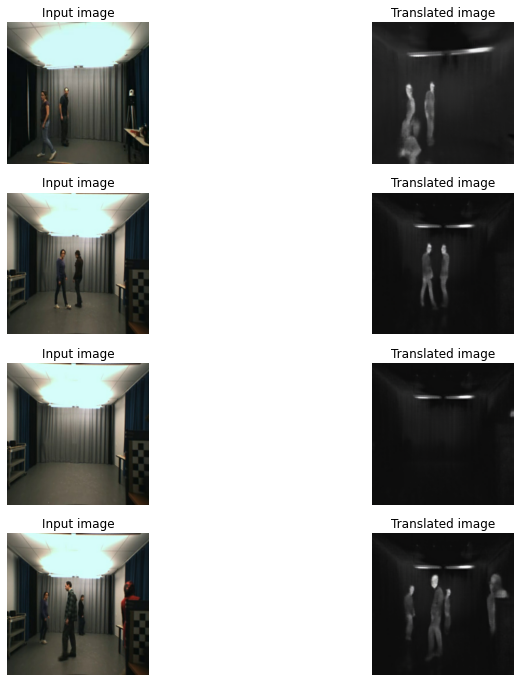

7599/7599 [==============================] - 2437s 321ms/step - G_loss: 0.6967 - F_loss: 0.9703 - D_X_loss: 0.1836 - D_Y_loss: 0.2338
Epoch 2/4
7599/7599 [==============================] - ETA: 0s - G_loss: 0.5742 - F_loss: 0.6676 - D_X_loss: 0.2381 - D_Y_loss: 0.2467

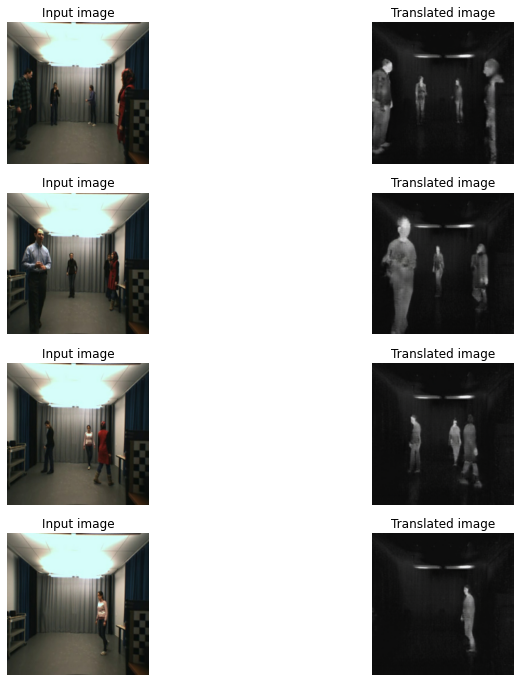

7599/7599 [==============================] - 2456s 323ms/step - G_loss: 0.5742 - F_loss: 0.6676 - D_X_loss: 0.2381 - D_Y_loss: 0.2467
Epoch 3/4
7599/7599 [==============================] - ETA: 0s - G_loss: 0.5361 - F_loss: 0.5911 - D_X_loss: 0.2430 - D_Y_loss: 0.2459

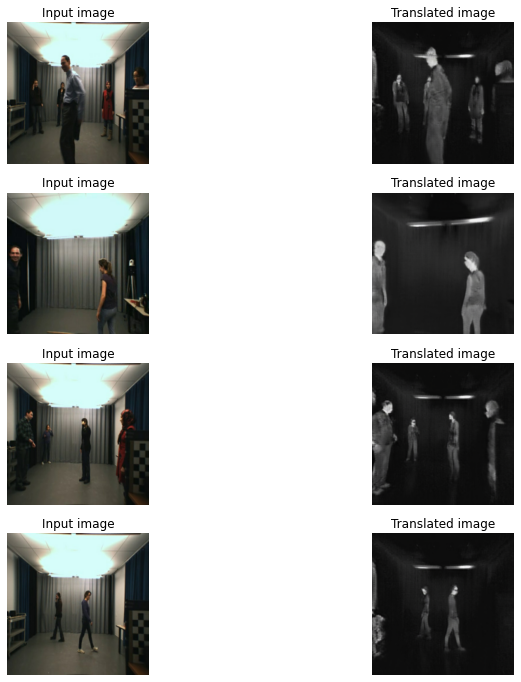

7599/7599 [==============================] - 2424s 319ms/step - G_loss: 0.5361 - F_loss: 0.5911 - D_X_loss: 0.2430 - D_Y_loss: 0.2459
Epoch 4/4
7599/7599 [==============================] - ETA: 0s - G_loss: 0.5178 - F_loss: 0.5533 - D_X_loss: 0.2443 - D_Y_loss: 0.2448

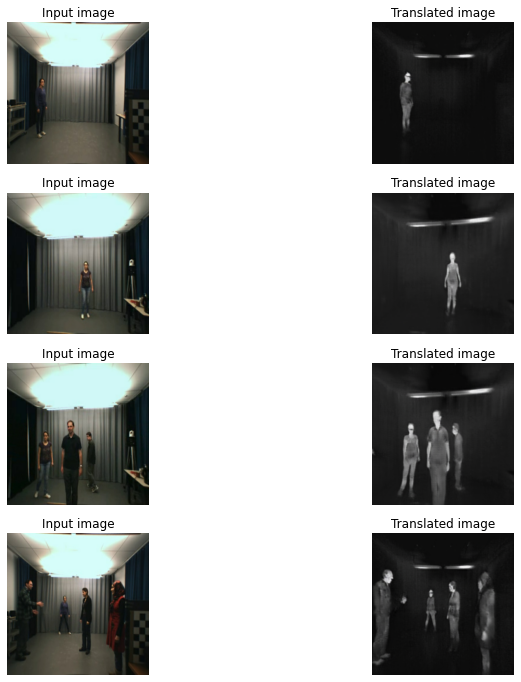

7599/7599 [==============================] - 2321s 305ms/step - G_loss: 0.5178 - F_loss: 0.5533 - D_X_loss: 0.2443 - D_Y_loss: 0.2448


In [15]:
adv_loss_fn = keras.losses.MeanSquaredError()

# Define the loss function for the generators
def generator_loss_fn(fake):
    fake_loss = adv_loss_fn(tf.ones_like(fake), fake)
    return fake_loss


# Define the loss function for the discriminators
def discriminator_loss_fn(real, fake):
    real_loss = adv_loss_fn(tf.ones_like(real), real)
    fake_loss = adv_loss_fn(tf.zeros_like(fake), fake)
    return (real_loss + fake_loss) * 0.5


# Create cycle gan model
cycle_gan_model = CycleGan(
    generator_G=gen_G, generator_F=gen_F, discriminator_X=disc_X, discriminator_Y=disc_Y
)

# Compile the model
cycle_gan_model.compile(
    gen_G_optimizer=keras.optimizers.Adam(learning_rate=1e-4, beta_1=0.8),
    gen_F_optimizer=keras.optimizers.Adam(learning_rate=1e-4, beta_1=0.8),
    disc_X_optimizer=keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.9),
    disc_Y_optimizer=keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.9),
    gen_loss_fn=generator_loss_fn,
    disc_loss_fn=discriminator_loss_fn,
)
# Callbacks
plotter = GANMonitor()
checkpoint_filepath = "./model_checkpoints/cyclegan_2_checkpoints.{epoch:03d}"
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath
)

# Here we will train the model for just one epoch as each epoch takes around
# 7 minutes on a single P100 backed machine.
cycle_gan_model.fit(
    tf.data.Dataset.zip((train_img, train_IR)),
    epochs=4,
    callbacks=[plotter, model_checkpoint_callback]
)

In [16]:
files = os.listdir('./image_test')
a=[]
for f in files:
    a.append('./image_test/'+f)
b=[]
c=[]
b=a[:10]
c=a[10:]

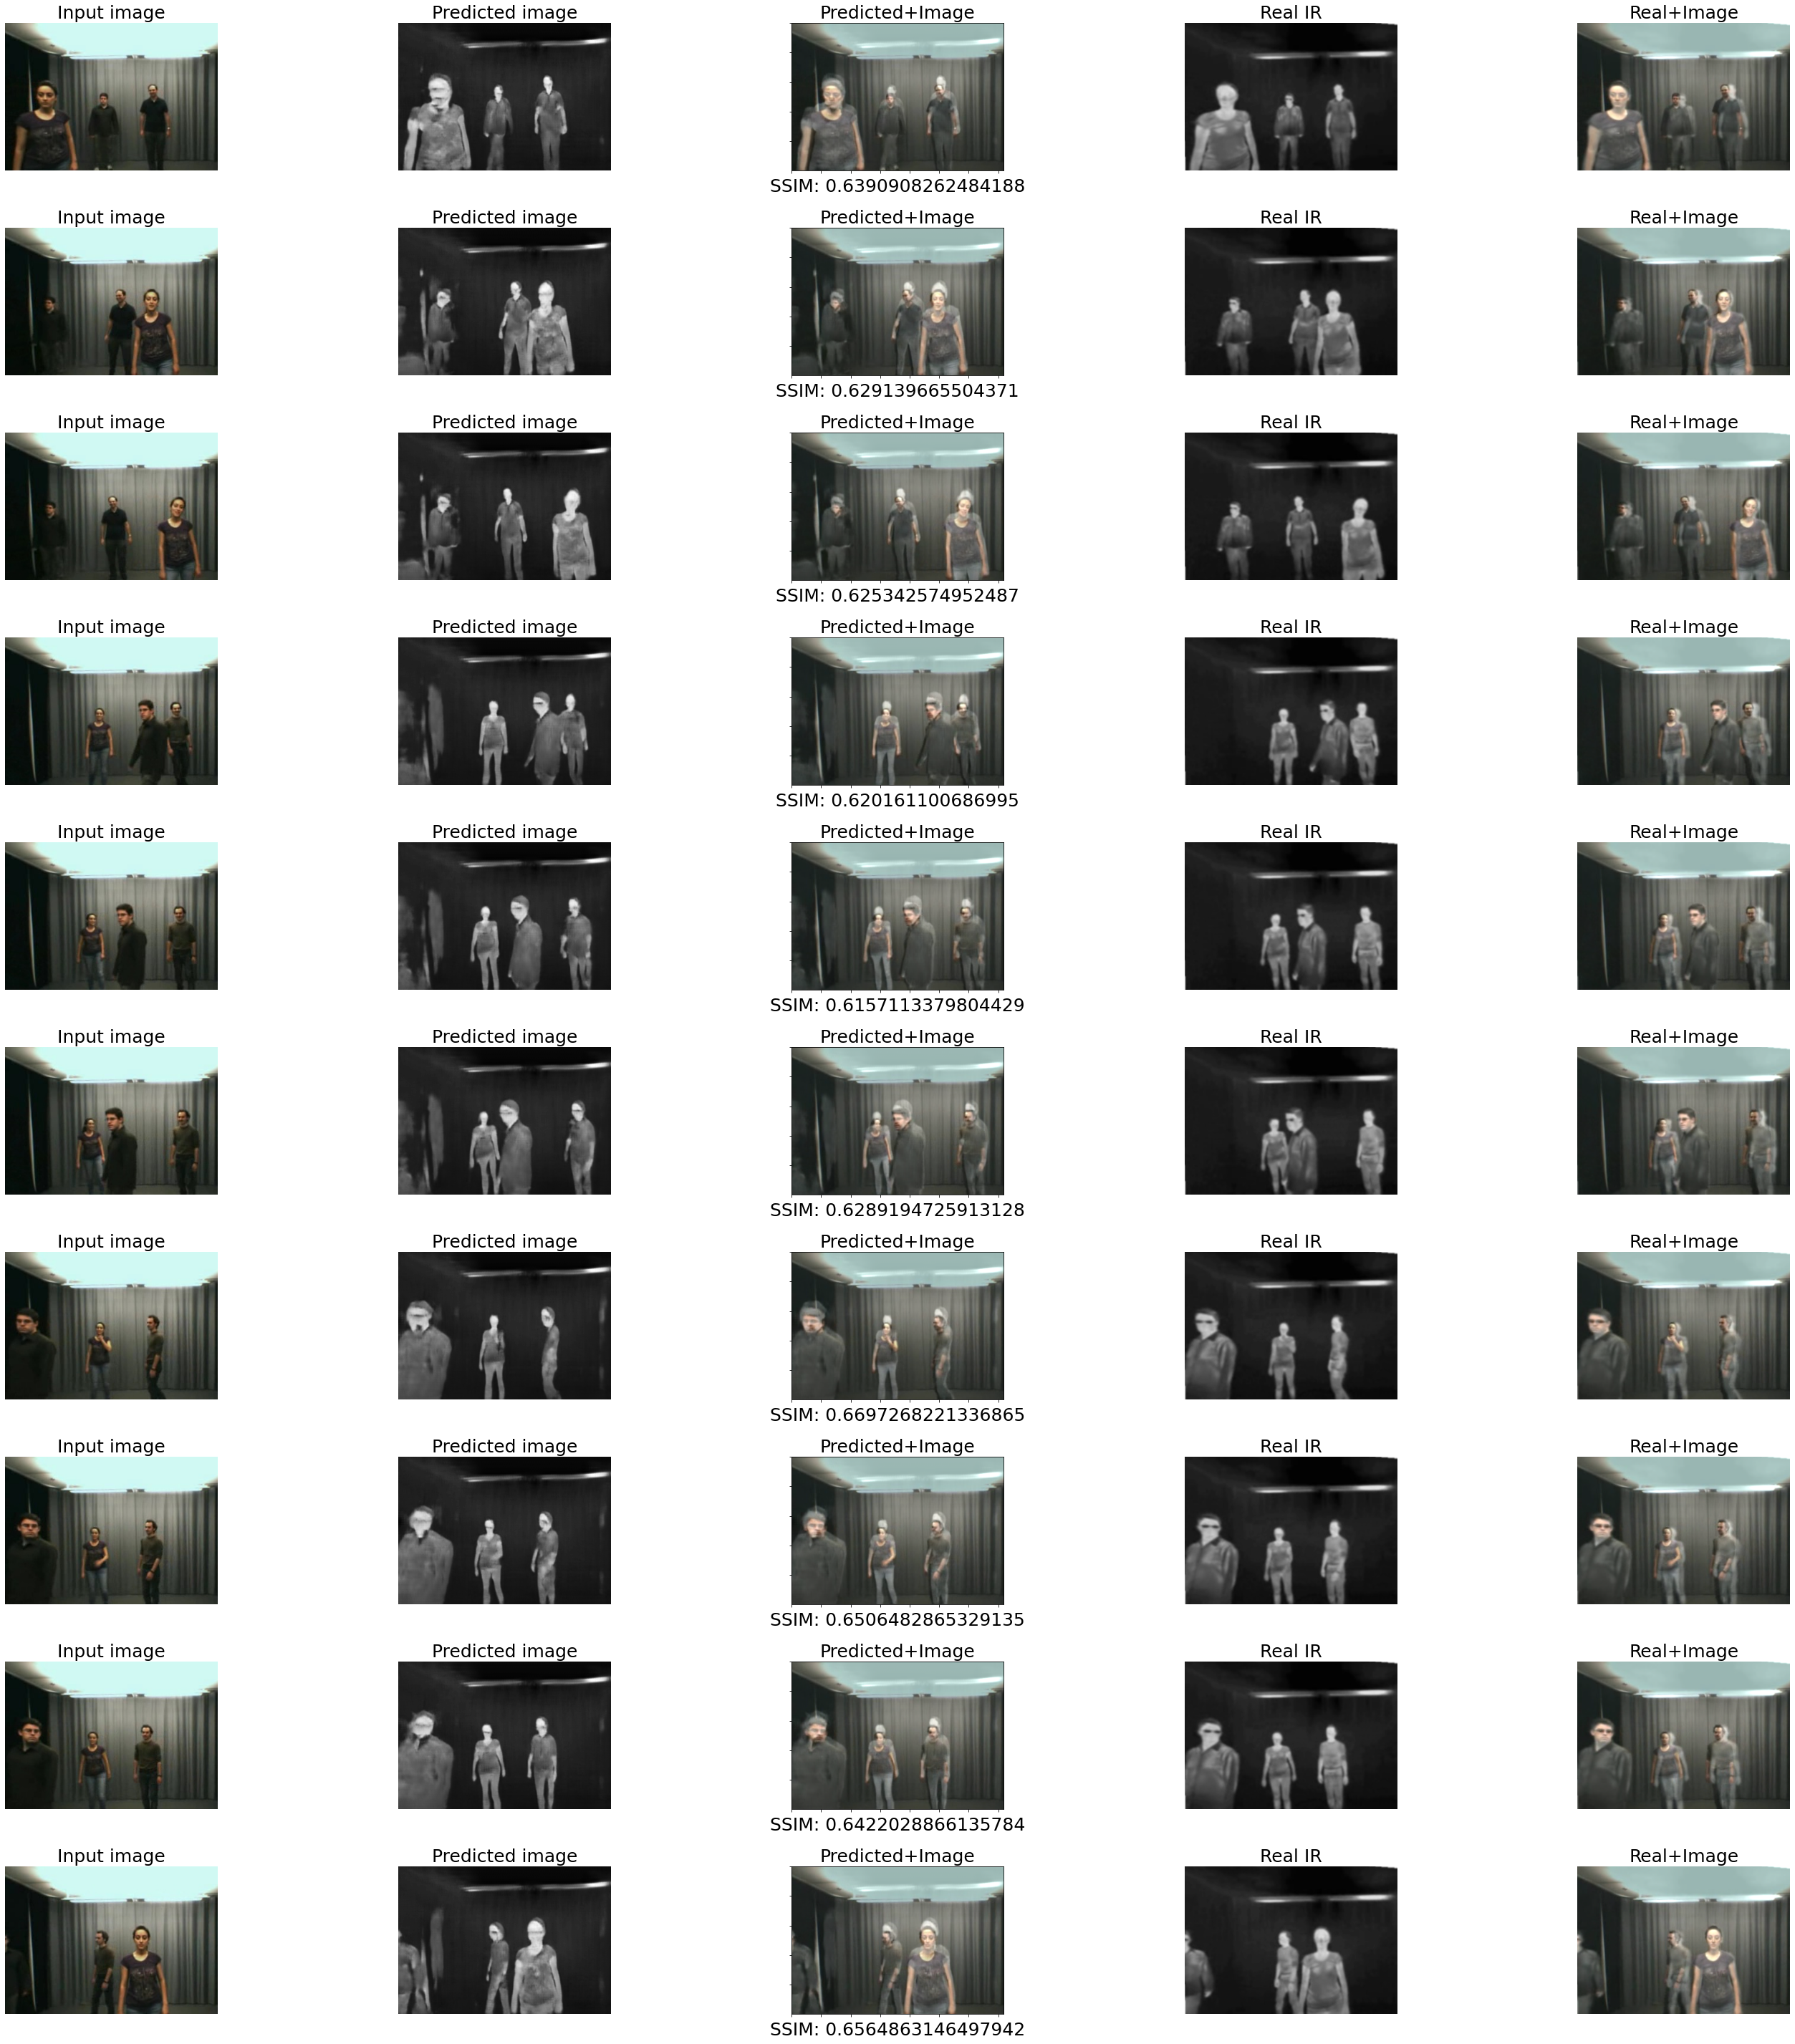

In [123]:
import cv2
from skimage.metrics import structural_similarity
_, ax = plt.subplots(10, 5, figsize=(40, 40))
for i in range(len(b)):
    
    img = cv2.imread(c[i])
    
    crop_img = img[50:300, 40:400]
    
    im_rgb = cv2.cvtColor(crop_img, cv2.COLOR_BGR2RGB)
    input_arr = keras.preprocessing.image.img_to_array(im_rgb)
    input_arr = np.array([input_arr])
    
    true_pred=cv2.imread(b[i])
    crop_true_colour = true_pred[50:300, 40:400]
    crop_true=cv2.cvtColor(crop_true_colour,cv2.COLOR_RGB2GRAY)
    

    prediction = cycle_gan_model.gen_G(input_arr, training=False)[0].numpy()
    
    img_pred_colour=((prediction*127.5)-127.5)
    

    img_pred=(cv2.cvtColor(img_pred_colour[0:250,:,:],cv2.COLOR_RGB2GRAY)).astype(np.uint8)


    score=structural_similarity(img_pred,crop_true)
    combined=cv2.addWeighted(im_rgb,0.7,((img_pred_colour[0:250,:,:]).astype(np.uint8)),0.6,0)
    combined_real=cv2.addWeighted(im_rgb,0.7,crop_true_colour,0.6,0)

    
    ax[i, 0].imshow(im_rgb)
    ax[i, 1].imshow((img_pred),cmap='gray')
    ax[i, 2].imshow(combined)
    ax[i, 3].imshow(crop_true,cmap='gray')
    ax[i, 4].imshow(combined_real)

    ax[i,2].xaxis.set_label_position('bottom')
    ax[i,2].set_xlabel("SSIM: "+str(score),fontsize=25)
    ax[i,2].set_xticklabels([])
    ax[i,2].set_yticklabels([])

    
    ax[i, 0].set_title("Input image",fontsize=25)
    ax[i, 1].set_title("Predicted image",fontsize=25)
    ax[i, 2].set_title("Predicted+Image",fontsize=25)
    ax[i, 3].set_title("Real IR",fontsize=25)
    ax[i, 4].set_title("Real+Image",fontsize=25)

    

    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
    ax[i, 3].axis("off")
    ax[i, 4].axis("off")


    #prediction = keras.preprocessing.image.array_to_img(prediction)
    #prediction.save("predicted_img_{i}.png".format(i=i))
plt.tight_layout(pad=2.0)
plt.show()

In [211]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import vgg19
total_variation_weight = 1e-6
style_weight = 1e-6
content_weight = 2.5e-8
result_prefix = "test"

width, height = keras.preprocessing.image.load_img('./data/image/img/0.jpg').size
img_nrows = 255
img_ncols = 255
from IPython.display import Image, display

#display(Image('./916ANCg.jpg'))
#display(Image(style_reference_image_path))

In [212]:
def preprocess_image(image_path):
    # Util function to open, resize and format pictures into appropriate tensors
    img = keras.preprocessing.image.load_img(
        image_path, target_size=(img_nrows, img_ncols)
    )
    img = keras.preprocessing.image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return tf.convert_to_tensor(img)


def deprocess_image(x):
    # Util function to convert a tensor into a valid image
    x = x.reshape((img_nrows, img_ncols, 3))
    # Remove zero-center by mean pixel
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    # 'BGR'->'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype("uint8")
    return x

# The gram matrix of an image tensor (feature-wise outer product)


def gram_matrix(x):
    x = tf.transpose(x, (2, 0, 1))
    features = tf.reshape(x, (tf.shape(x)[0], -1))
    gram = tf.matmul(features, tf.transpose(features))
    return gram


# The "style loss" is designed to maintain
# the style of the reference image in the generated image.
# It is based on the gram matrices (which capture style) of
# feature maps from the style reference image
# and from the generated image


def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_nrows * img_ncols
    return tf.reduce_sum(tf.square(S - C)) / (4.0 * (channels ** 2) * (size ** 2))


# An auxiliary loss function
# designed to maintain the "content" of the
# base image in the generated image


def content_loss(base, combination):
    return tf.reduce_sum(tf.square(combination - base))


# The 3rd loss function, total variation loss,
# designed to keep the generated image locally coherent


def total_variation_loss(x):
    a = tf.square(
        x[:, : img_nrows - 1, : img_ncols - 1, :] - x[:, 1:, : img_ncols - 1, :]
    )
    b = tf.square(
        x[:, : img_nrows - 1, : img_ncols - 1, :] - x[:, : img_nrows - 1, 1:, :]
    )
    return tf.reduce_sum(tf.pow(a + b, 1.25))

# Build a VGG19 model loaded with pre-trained ImageNet weights
model = vgg19.VGG19(weights="imagenet", include_top=False)

# Get the symbolic outputs of each "key" layer (we gave them unique names).
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])

# Set up a model that returns the activation values for every layer in
# VGG19 (as a dict).
feature_extractor = keras.Model(inputs=model.inputs, outputs=outputs_dict)

# List of layers to use for the style loss.
style_layer_names = [
    "block1_conv1",
    "block2_conv1",
    "block3_conv1",
    "block4_conv1",
    "block5_conv1",
]
# The layer to use for the content loss.
content_layer_name = "block5_conv2"


def compute_loss(combination_image, base_image, style_reference_image):
    input_tensor = tf.concat(
        [base_image, style_reference_image, combination_image], axis=0
    )
    features = feature_extractor(input_tensor)

    # Initialize the loss
    loss = tf.zeros(shape=())

    # Add content loss
    layer_features = features[content_layer_name]
    base_image_features = layer_features[0, :, :, :]
    combination_features = layer_features[2, :, :, :]
    loss = loss + content_weight * content_loss(
        base_image_features, combination_features
    )
    # Add style loss
    for layer_name in style_layer_names:
        layer_features = features[layer_name]
        style_reference_features = layer_features[1, :, :, :]
        combination_features = layer_features[2, :, :, :]
        sl = style_loss(style_reference_features, combination_features)
        loss += (style_weight / len(style_layer_names)) * sl

    # Add total variation loss
    loss += total_variation_weight * total_variation_loss(combination_image)
    return loss

In [213]:
@tf.function
def compute_loss_and_grads(combination_image, base_image, style_reference_image):
    with tf.GradientTape() as tape:
        loss = compute_loss(combination_image, base_image, style_reference_image)
    grads = tape.gradient(loss, combination_image)
    return loss, grads

In [214]:
files = os.listdir('./image_test')
a=[]
for f in files:
    a.append('./image_test/'+f)
b=[]
c=[]
b=a[:10]
c=a[10:]

In [216]:
import glob
filelist_img = glob.glob('./tmp_data/image/img/*.jpg')
    

New model (#0)
Model took:3835.230042864976 seconds
Loss: tf.Tensor(72.23285, shape=(), dtype=float32)
New model (#1)
Model took:3780.711834597052 seconds
Loss: tf.Tensor(69.783485, shape=(), dtype=float32)
New model (#2)
Model took:3803.4750436030445 seconds
Loss: tf.Tensor(68.79874, shape=(), dtype=float32)
New model (#3)
Model took:3798.636485185998 seconds
Loss: tf.Tensor(68.84993, shape=(), dtype=float32)
New model (#4)
Model took:4069.0620463090017 seconds
Loss: tf.Tensor(73.00885, shape=(), dtype=float32)
New model (#5)
Model took:4082.386796712992 seconds
Loss: tf.Tensor(68.48716, shape=(), dtype=float32)
New model (#6)
Model took:4095.192522346042 seconds
Loss: tf.Tensor(51.1447, shape=(), dtype=float32)
New model (#7)
Model took:4094.617807461007 seconds
Loss: tf.Tensor(50.888535, shape=(), dtype=float32)
New model (#8)
Model took:4093.6825685430085 seconds
Loss: tf.Tensor(52.02957, shape=(), dtype=float32)
New model (#9)
Model took:4093.2963966449606 seconds
Loss: tf.Tensor(

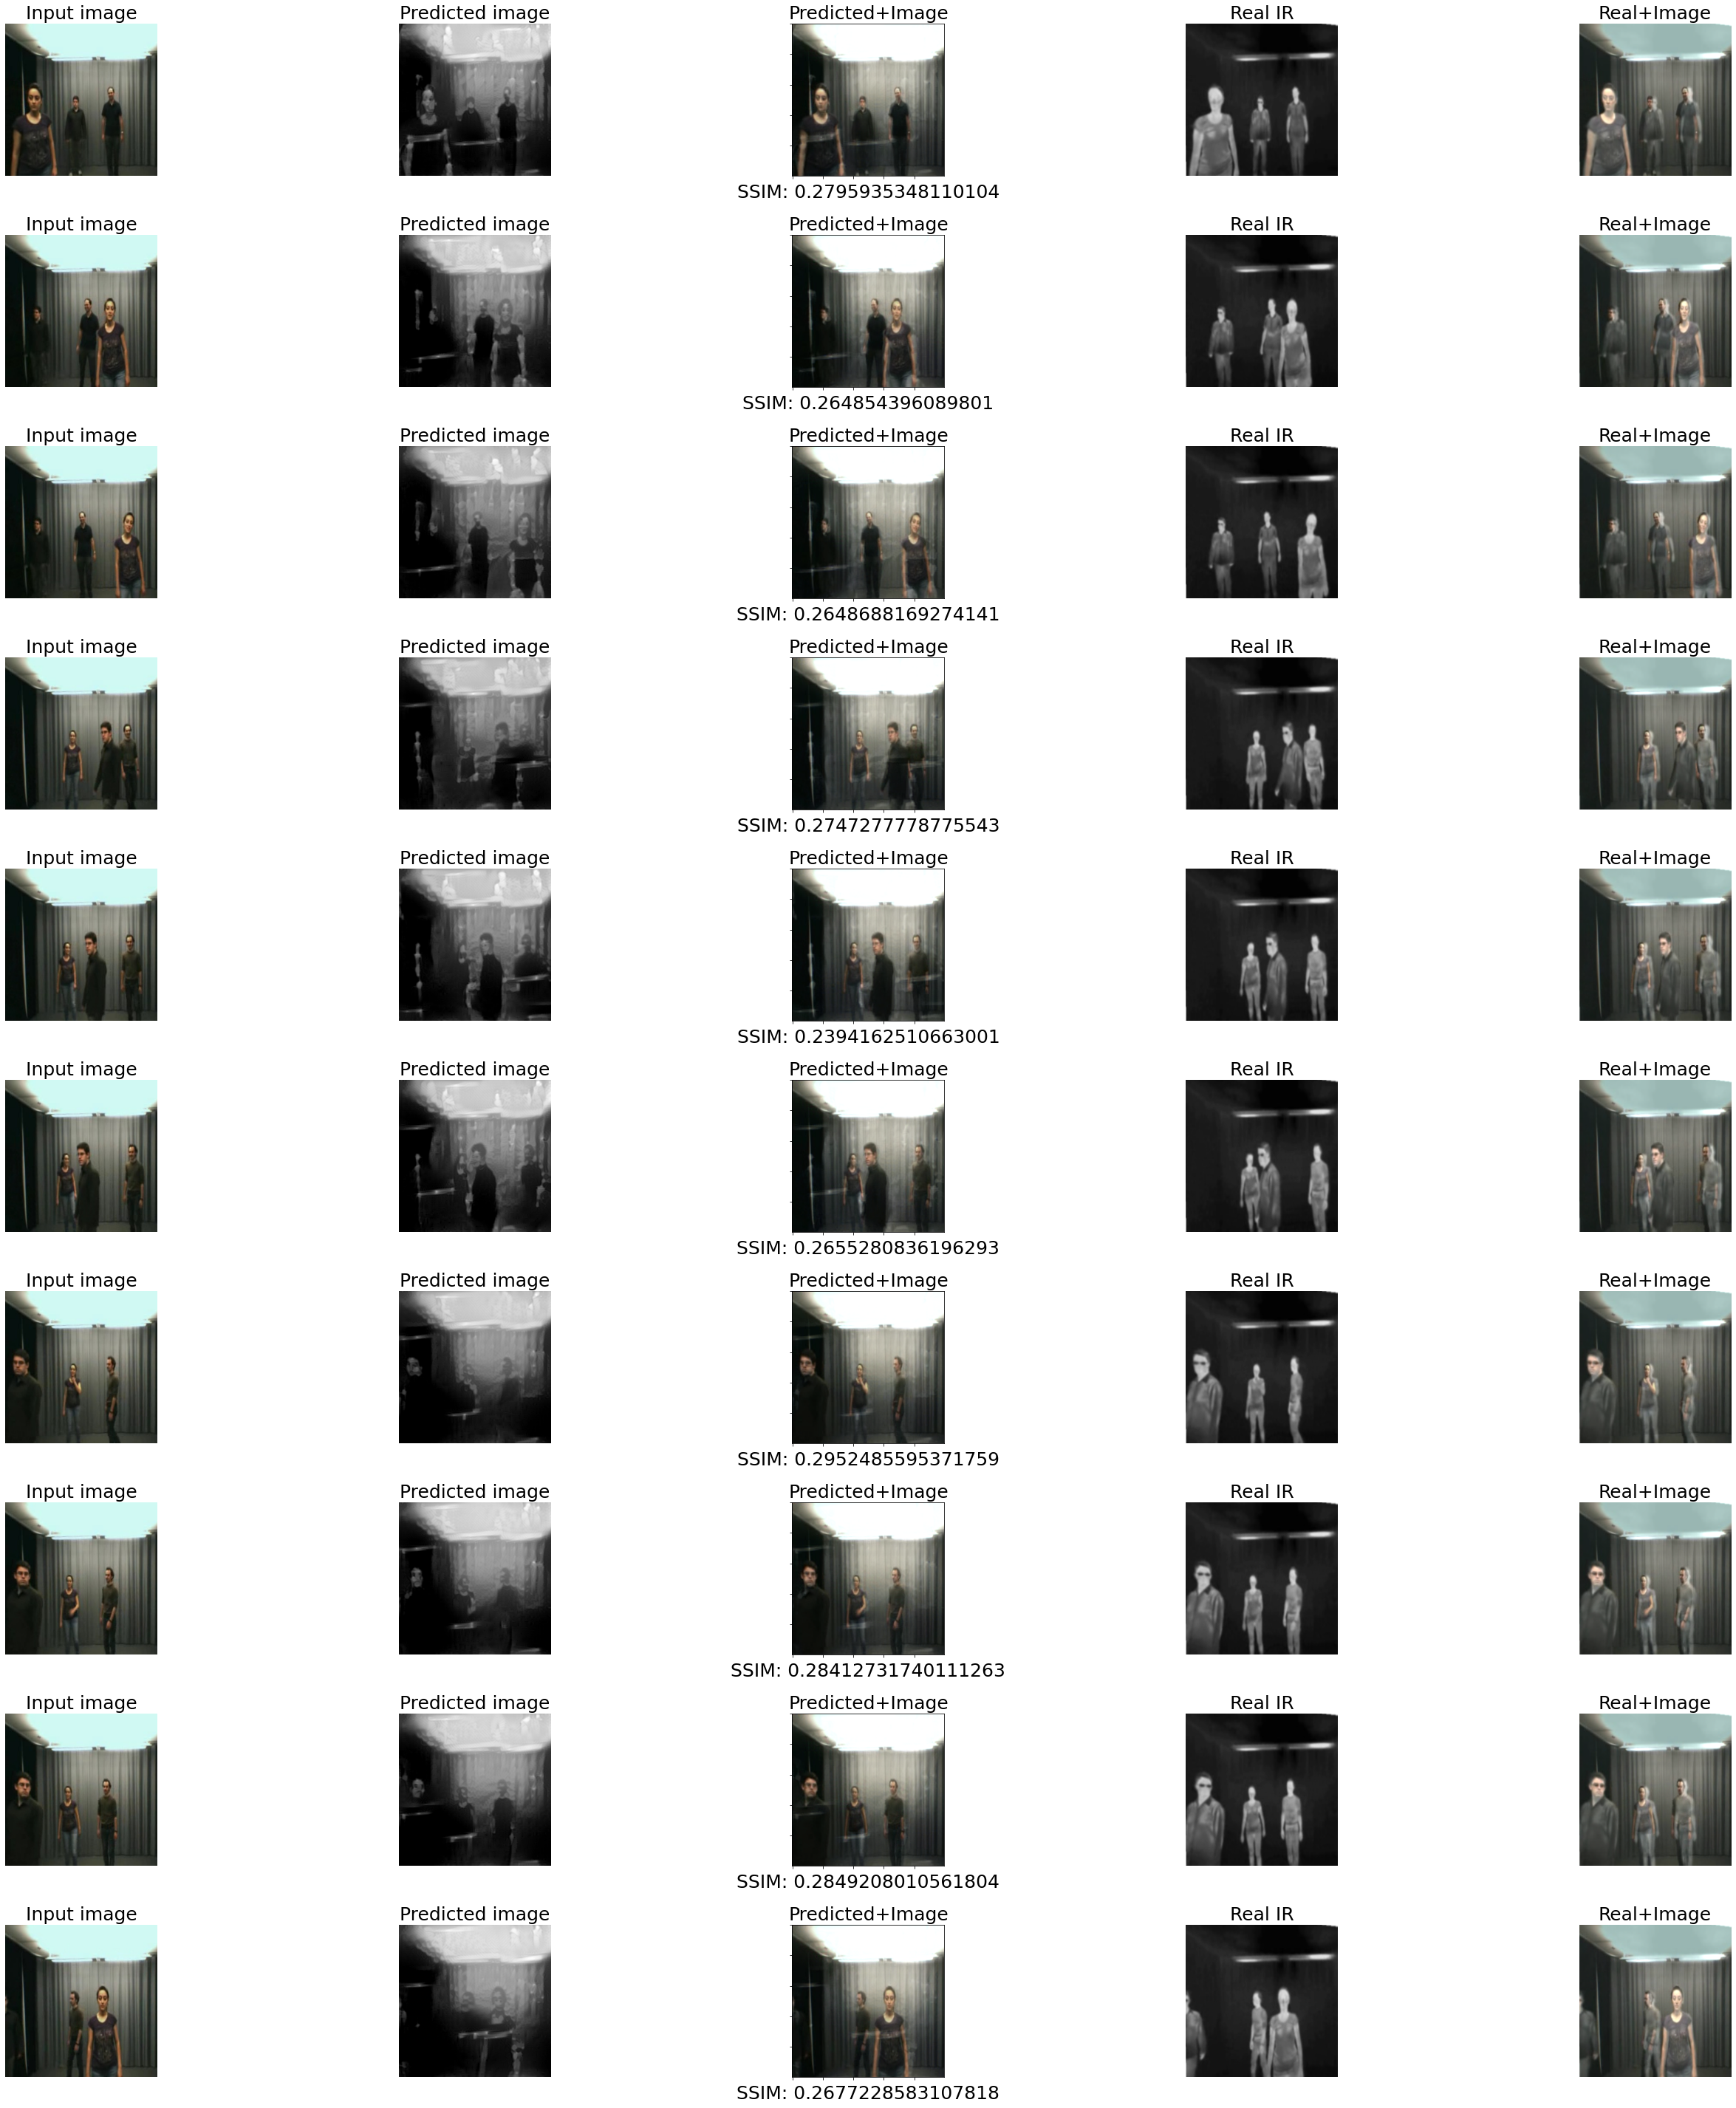

In [237]:
_, ax = plt.subplots(10, 5, figsize=(40, 40))
import cv2
import time
combination_image = tf.Variable(preprocess_image('./tmp_data/masks/mask/0.jpg'))
from skimage.metrics import structural_similarity
#_, ax = plt.subplots(10, 5, figsize=(40, 40))
for i in range(len(c)):
    
    #Read test image, remove white barrier, crop to our size, write it as temp
    img = cv2.imread(c[i])
    crop_img = img[50:300, 40:400]
    final_img=cv2.cvtColor(crop_img,cv2.COLOR_BGR2RGB)
    resized_crop_img_250=cv2.resize(final_img,(250,250))
    #resized_crop_img_250=cv2.cvtColor(resized_crop_img_250,cv2.COLOR_RGB2GRAY)

    final_img=cv2.resize(crop_img,(480,360))
    cv2.imwrite('./tmp/.only_temp.png',final_img)
    
    #Read real IR, same crop, same resize and proper channel switch
    true_pred=cv2.imread(b[i])
    crop_true_colour = true_pred[50:300, 40:400]
    crop_true_colour=cv2.resize(crop_true_colour,(250,250))
    crop_true=cv2.cvtColor(crop_true_colour,cv2.COLOR_BGR2GRAY)
    
    
    
    min_path='./tmp_data/image/img/0.jpg'
    x=cv2.imread(min_path)
    x=cv2.cvtColor(x,cv2.COLOR_BGR2RGB)

    s = structural_similarity(resized_crop_img, x,multichannel=True)
    min_=s
    

    
    for itt_bestscore in range(0,len(filelist_img),30):
        y=cv2.imread(filelist_img[itt_bestscore])
        s = structural_similarity(final_img, y,multichannel=True)
        if s>min_:
            min_=s
            min_path=filelist_img[itt_bestscore]
     
    print("New model (#"+str(i)+')')
    new_time=time.perf_counter()
    
    optimizer = keras.optimizers.SGD(keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=100.0, decay_steps=1000, decay_rate=0.96))
    base_image = preprocess_image('./tmp/.only_temp.png')
    style_reference_image = preprocess_image('./tmp_data/masks/mask/'+min_path[-8:])
    combination_image.assign(preprocess_image('./tmp/.only_temp.png'))

    flag_iter=1
    iterations = 150000
    
    for itt_train in range(1, iterations + 1):
        loss, grads = compute_loss_and_grads(combination_image, base_image, style_reference_image)
        optimizer.apply_gradients([(grads, combination_image)])
        if itt_train % 100 == 0:
            if flag_iter:
                best_loss=loss
                flag_iter=0
                img = deprocess_image(combination_image.numpy())
            else:
                if best_loss>loss:
                    best_loss=loss
                    flag_iter=0
                    img = deprocess_image(combination_image.numpy())
                else:
                    pass

    print("Model took:"+str(time.perf_counter()-new_time)+' seconds')
    print("Loss: "+str(best_loss))
    img_pred_gray=cv2.cvtColor(img[0:250,0:250,:],cv2.COLOR_RGB2GRAY)
    img_pred=img[0:250,0:250,:]


    score=structural_similarity(img_pred_gray,crop_true)
    combined=cv2.addWeighted(resized_crop_img_250,0.7,img_pred,0.6,0)
    combined_real=cv2.addWeighted(resized_crop_img_250,0.7,crop_true_colour,0.6,0)
    
    ax[i, 0].imshow(resized_crop_img_250)
    ax[i, 1].imshow((img_pred_gray),cmap='gray')
    ax[i, 2].imshow(combined)
    
    ax[i, 3].imshow(crop_true,cmap='gray')
    ax[i, 4].imshow(combined_real)

    ax[i,2].xaxis.set_label_position('bottom')
    ax[i,2].set_xlabel("SSIM: "+str(score),fontsize=25)
    ax[i,2].set_xticklabels([])
    ax[i,2].set_yticklabels([])

    
    ax[i, 0].set_title("Input image",fontsize=25)
    ax[i, 1].set_title("Predicted image",fontsize=25)
    ax[i, 2].set_title("Predicted+Image",fontsize=25)
    ax[i, 3].set_title("Real IR",fontsize=25)
    ax[i, 4].set_title("Real+Image",fontsize=25)

    

    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
    ax[i, 3].axis("off")
    ax[i, 4].axis("off")


    #prediction = keras.preprocessing.image.array_to_img(prediction)
    #prediction.save("predicted_img_{i}.png".format(i=i))
plt.tight_layout(pad=2.0)
plt.show()